In [1]:
!pip install matplotlib seaborn scikit-learn pandas numpy wordcloud nltk

### Project Overview: Stock Sentiment, Predicting market behavior from tweets 

The goal of this project is to predict market behavior from tweets.

To evaluate the tweets, they are classiefied according to the following labels: 

- **.Bearish (0)**: Negative sentiment
- **.Bullish (1)**: Positive sentiment
- **.Neutral (2)**: No sentiment


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import ast

In [3]:
train = pd.read_csv(r'/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/2º Semestre/Text Mining/group project/train.csv')
train 

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
...,...,...
9538,The Week's Gainers and Losers on the Stoxx Eur...,2
9539,Tupperware Brands among consumer gainers; Unil...,2
9540,vTv Therapeutics leads healthcare gainers; Myo...,2
9541,"WORK, XPO, PYX and AMKR among after hour movers",2


In [4]:
test_df = pd.read_csv(r'/Users/pedrocosta/Desktop/NOVA IMS/Mestrado DSAA/2º Semestre/Text Mining/group project/test.csv') 
test_df

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."
...,...,...
2383,2383,$IVC - Invacare Corporation (IVC) CEO Matthew ...
2384,2384,"Domtar EPS misses by $0.05, revenue in-line"
2385,2385,India Plans Incentives to Bring In Foreign Man...
2386,2386,$NVCR shows institutional accumulation with bl...


# EDA

In [5]:
train.duplicated().sum()

np.int64(0)

In [6]:
train.shape

(9543, 2)

In [7]:
train.columns

Index(['text', 'label'], dtype='object')

In [8]:
train.head(10)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0
5,$FTI - TechnipFMC downgraded at Berenberg but ...,0
6,$GM - GM loses a bull https://t.co/tdUfG5HbXy,0
7,$GM: Deutsche Bank cuts to Hold https://t.co/7...,0
8,$GTT: Cowen cuts to Market Perform,0
9,$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone e...,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


In [10]:
train.describe()

,label
count,9543.000000
mean,1.496280
std,0.743139
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,2.000000


In [11]:
(train['text']).unique()

array(['$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT',
       '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3',
       '$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb',
       ...,
       'vTv Therapeutics leads healthcare gainers; Myomo and Biohaven Pharmaceutical among losers',
       'WORK, XPO, PYX and AMKR among after hour movers',
       'YNDX, I, QD and OESX among tech movers'],
      shape=(9543,), dtype=object)

From the above table, we can get some conclusions. 
- `count`- There are 9543 tweets with valid sentiments. 
- `mean`- On average, tweets are more prone to be neutral;
- `std`- Standard deviation (0.74 on a scale from 0 to 2) indicates some diversity, but not perfect balance. It’s skewed toward neutral and bullish.
- `25%, 50%, 75%`- The median, 25%, and 75% percentiles are all ≥ 1, with 50% and 75% being exactly 2
- Since the 25% percentile is 1, only 25% of tweets are either bearish (0) or bullish (1) and given that the mean is 1.5, bearish (0) tweets are likely the least frequent.
- Class 2 (neutral) is overrepresented, and class 0 (bearish) is underrepresented.

In [12]:
train.select_dtypes(include='number').skew()

label   -1.09216
dtype: float64

Highly skewed 

In [13]:
train['label'].kurt()

np.float64(-0.3388194691929236)

In [14]:
label_counts=train['label'].value_counts()
label_percentage=train['label'].value_counts(normalize=True)
summary_df = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentage.round(2)
})

print(summary_df)


       Count  Percentage (%)
label                       
2       6178            0.65
1       1923            0.20
0       1442            0.15


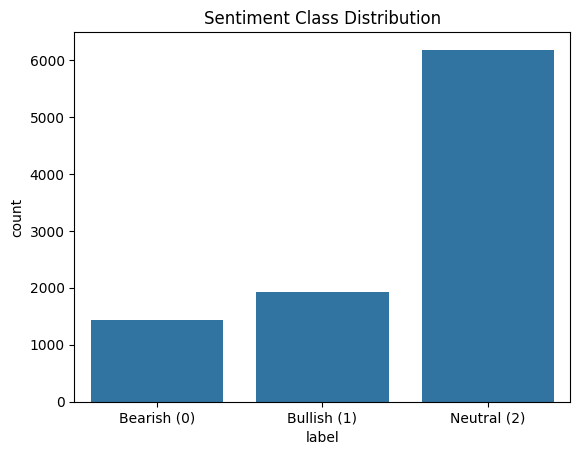

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train)
plt.title("Sentiment Class Distribution")
plt.xticks(ticks=[0, 1, 2], labels=["Bearish (0)", "Bullish (1)", "Neutral (2)"])
plt.show()

### There is class imbalance, we have to train on equal values.

##Categorical

In [16]:
train.describe(include = ['O'])

,text
count,9543
unique,9543
top,$BYND - JPMorgan reels in expectations on Beyo...
freq,1


In [17]:
#Check a random text
train['text'][10]

"$HOG - Moody's warns on Harley-Davidson https://t.co/LurHBEadeU"

In [18]:
train['word_count']  = train['text'].apply(lambda x: len(str(x).split(" ")))
train[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


In [19]:
train.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

In [20]:
train['text'].isna().sum()

np.int64(0)

### Words per tweet statistics

- `mean`: On average it's written 12 words.
- `std`: Its small, the interval is between 8 and 16.
- `min`: 1 word tweets, can be erased perhaps.
- `75%`: 75% of tweets have 15 words or less.


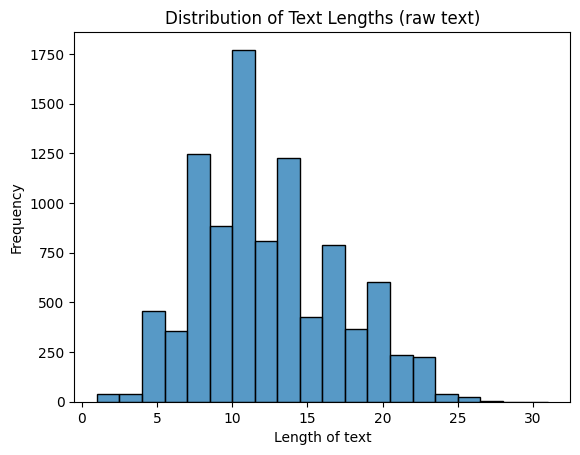

In [21]:
#Plot distribution of text length
sns.histplot(train['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

In [22]:
all_words = ' '.join(train['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

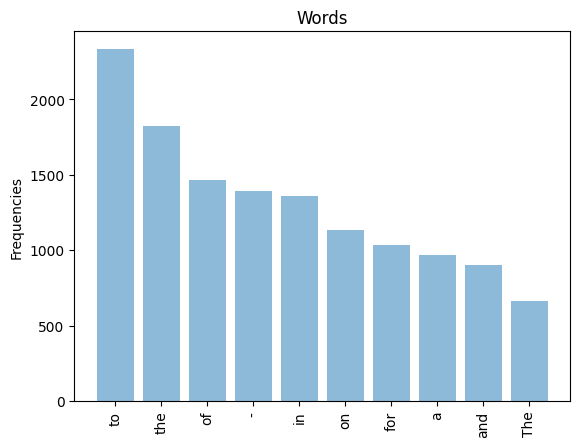

In [23]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

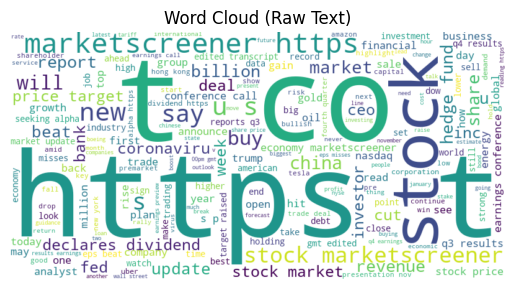

In [24]:
# 🌥️ Create a word cloud from the raw text
raw_text = ' '.join(train['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

# Pre-Processing

In [25]:
#!pip install nltk
#!pip install strings

In [26]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [27]:
# 🧠 Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [29]:
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Load required resources
stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
ps = PorterStemmer()

def clean(text_list, lemmatize=True, stemmer=False):
    updates = []

    for j in tqdm(text_list):
        # LOWERCASE TEXT
        text_lower = j.lower()

        # REMOVE NUMBERS, SYMBOLS, URLs, and PUNCTUATION
        text_lower = re.sub("[^a-zA-Z]", " ", text_lower)
        text_lower = re.sub("br", "", text_lower)
        text_lower = re.sub(r'http\S+', '', text_lower)
        text_lower = re.sub(f"[{re.escape(string.punctuation)}]", '', text_lower)

        # REMOVE STOPWORDS
        text_lower = " ".join([word for word in text_lower.split() if word not in stop])

        # LEMMATIZE
        if lemmatize:
            text_lower = " ".join(lemma.lemmatize(word) for word in text_lower.split())

        # STEM
        if stemmer:
            text_lower = " ".join(ps.stem(word) for word in text_lower.split())

        updates.append(text_lower)

    return updates

In [30]:
updates = clean(train['text'], lemmatize = True, stemmer = False)

100%|██████████| 9543/9543 [00:02<00:00, 4728.17it/s]


In [31]:
updates[40]

'autodesk downgraded underweight neutral jpmorgan'

In [32]:
train['text'][40]

'Autodesk downgraded to underweight from neutral at JPMorgan'

In [33]:
def update_df(dataframe, list_updated):
    dataframe['text'] = list_updated

In [34]:

update_df(train, updates)
train.head()

,text,label,word_count
0,bynd jpmorgan reel expectation beyond meat co ...,0,10
1,ccl rcl nomura point booking weakness carnival...,0,14
2,cx cemex cut credit suisse j p morgan weak bui...,0,14
3,es btig research cut neutral co mcyftsxc n,0,7
4,fnko funko slide piper jaffray pt cut co z ijm...,0,10


In [35]:
train

,text,label,word_count
0,bynd jpmorgan reel expectation beyond meat co ...,0,10
1,ccl rcl nomura point booking weakness carnival...,0,14
2,cx cemex cut credit suisse j p morgan weak bui...,0,14
3,es btig research cut neutral co mcyftsxc n,0,7
4,fnko funko slide piper jaffray pt cut co z ijm...,0,10
...,...,...,...
9538,week gainer loser stoxx europe dec economy mar...,2,16
9539,tupperware ands among consumer gainer unilever...,2,9
9540,vtv therapeutic lead healthcare gainer myomo b...,2,11
9541,work xpo pyx amkr among hour mover,2,9


# Bag of Words (Bow)

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [37]:
bow = CountVectorizer(binary=True)
X = bow.fit_transform(train["text"])

In [38]:
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 88252 stored elements and shape (9543, 19904)>

In [39]:
print(X[10:13].toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [40]:
print(bow.get_feature_names_out()[10000:10022])

['los' 'lose' 'loser' 'loses' 'losing' 'loss' 'lost' 'lot' 'lotos' 'lotpf'
 'lottery' 'louder' 'louis' 'louisiana' 'love' 'loved' 'lovely' 'lover'
 'lovesac' 'loving' 'low' 'lowbonar']


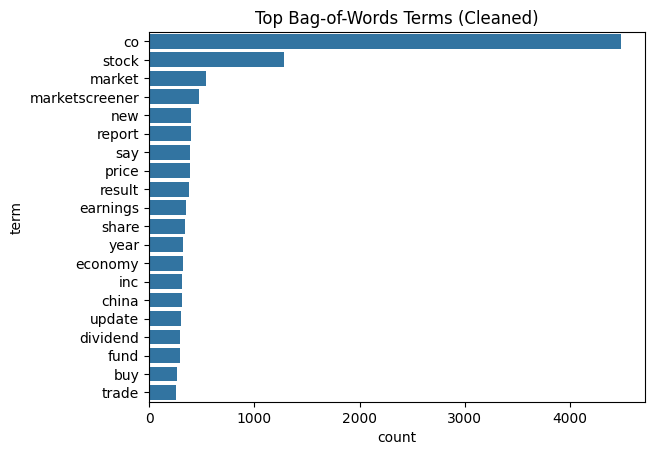

In [41]:
# 🔍 Visualize top Bag of Words terms (Cleaned)
clean_bow_sum = np.array(X.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(20)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

# Define Labels

In [42]:
y = np.array(train['label'])

In [43]:
y[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
len(y)

9543

## BALANCE LABEL

In [45]:
import pandas as pd
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

# --- Setup NLTK ---
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
ps = PorterStemmer()

# --- 1. Clean function ---
def clean(text_list, lemmatize=True, stemmer=False):
    updates = []
    for j in tqdm(text_list):
        text_lower = j.lower()
        text_lower = re.sub("[^a-zA-Z]", " ", text_lower)
        text_lower = re.sub("br", "", text_lower)
        text_lower = re.sub(r'http\S+', '', text_lower)
        text_lower = re.sub(f"[{re.escape(string.punctuation)}]", '', text_lower)
        text_lower = " ".join([word for word in text_lower.split() if word not in stop])
        if lemmatize:
            text_lower = " ".join(lemma.lemmatize(word) for word in text_lower.split())
        if stemmer:
            text_lower = " ".join(ps.stem(word) for word in text_lower.split())
        updates.append(text_lower)
    return updates

# --- 2. Clean the training set ---
train['text_clean'] = clean(train['text'].tolist(), lemmatize=True, stemmer=False)

# --- 3. Balance the cleaned data ---
df_0 = train[train['label'] == 0]
df_1 = train[train['label'] == 1]
df_2 = train[train['label'] == 2]

min_count = min(len(df_0), len(df_1), len(df_2))

df_0 = resample(df_0, n_samples=min_count, random_state=42)
df_1 = resample(df_1, n_samples=min_count, random_state=42)
df_2 = resample(df_2, n_samples=min_count, random_state=42)

train_balanced = pd.concat([df_0, df_1, df_2]).sample(frac=1, random_state=42)

# --- 4. Vectorize ---
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_balanced['text_clean'])
y_train = train_balanced['label']

# --- 5. Train KNN ---
modelknn = KNeighborsClassifier(n_neighbors=100, metric='cosine', weights='distance')
modelknn.fit(X_train, y_train)

# --- 6. Prepare new test sentences ---
test_sentences = [
    "the Disney stock is bad.",
    "the report on Apple is good."
]

test_clean = clean(test_sentences, lemmatize=True, stemmer=False)
X_test = vectorizer.transform(test_clean)
predictions = modelknn.predict(X_test)

# --- 7. Show results ---
label_names = {0: "Negative", 1: "Positive", 2: "Neutral"}

for original, pred in zip(test_sentences, predictions):
    print(f"'{original}' → Predicted label: {label_names[pred]}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pedrocosta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 2/2 [00:00<00:00, 23301.69it/s]

'the Disney stock is bad.' → Predicted label: Positive
'the report on Apple is good.' → Predicted label: Neutral


In [46]:
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.utils import resample


In [47]:
# Balance dataset
df_0 = train[train['label'] == 0]
df_1 = train[train['label'] == 1]
df_2 = train[train['label'] == 2]

min_count = min(len(df_0), len(df_1), len(df_2))

train_balanced = pd.concat([
    resample(df_0, n_samples=min_count, random_state=42),
    resample(df_1, n_samples=min_count, random_state=42),
    resample(df_2, n_samples=min_count, random_state=42)
]).sample(frac=1, random_state=42)

# Vectorize
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_balanced['text'])
y_train = train_balanced['label']


# Train Classifier

In [48]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
modelknn = KNeighborsClassifier(n_neighbors = 100, metric = 'cosine', weights = 'distance')

In [50]:
modelknn.fit(X_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=100, weights='distance')

In [51]:
# Clean function ---
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from tqdm import tqdm

stop = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
ps = PorterStemmer()

In [52]:
def clean(text_list, lemmatize=True, stemmer=False):
    updates = []
    for j in tqdm(text_list):
        text_lower = j.lower()
        text_lower = re.sub("[^a-zA-Z]", " ", text_lower)
        text_lower = re.sub("br", "", text_lower)
        text_lower = re.sub(r'http\S+', '', text_lower)
        text_lower = re.sub(f"[{re.escape(string.punctuation)}]", '', text_lower)
        text_lower = " ".join([word for word in text_lower.split() if word not in stop])
        if lemmatize:
            text_lower = " ".join(lemma.lemmatize(word) for word in text_lower.split())
        if stemmer:
            text_lower = " ".join(ps.stem(word) for word in text_lower.split())
        updates.append(text_lower)
    return updates

In [53]:

test_sentences = pd.DataFrame({'text': [
    "the Disney stock is bad.",
    "the report on Apple is good."
]})

In [54]:
test_clean = clean(test_sentences, lemmatize = True, stemmer = False)

 50%|█████     | 1/2 [00:00<00:00, 9425.40it/s]


In [55]:
test_clean

['text']

In [56]:
# Transform them using the vectorizer trained on train data
X_test = vectorizer.transform(test_clean)

# 4. Predict
predictions = modelknn.predict(X_test)

# 5. Display
for original, pred in zip(test_sentences, predictions):
    print(f"'{original}' → Predicted label: {pred}")

'text' → Predicted label: 0


## Predict - apply KNN

In [57]:
predict = modelknn.predict(test)

NameError: name 'test' is not defined

In [ ]:
predict

In [ ]:
for review, score in zip(test_sentences, predict):
    print(f'The predicted score for the review: "{review}", is {score}.')